In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import geopandas as gpd
from pathlib import Path
import os
import numpy as np

import warnings
warnings.filterwarnings("ignore")

from matplotlib.lines import Line2D

from matplotlib.colors import ListedColormap
colors = ["#005845", "#84C497", "#F28E77", "#64C1CB", "#F3A44C"]
syke5 = ListedColormap(colors)

custom_lines = [Line2D([0], [0], color=syke5(0.0), lw=4),
                Line2D([0], [0], color=syke5(.25), lw=4),
                Line2D([0], [0], color=syke5(.50), lw=4),
                Line2D([0], [0], color=syke5(.75), lw=4),
                Line2D([0], [0], color=syke5(1.0), lw=4),]

model_path = Path('../runs')

# Cross-validation

Evaluate the cross-validation performance of different YOLOv8 models.

Metrics used here are the following:

* $Precision = \frac{tp}{tp+fp}$, with IoU-threshold of 0.5
* $Recall = \frac{tp}{tp+fn}$, with IoU-threshold of 0.5
* $mAP50$ is the area under the precision-recall curve with IoU threshold of 0.5
* $mAP$ or $AP@[.5:.95]$ is the average $mAP$ for IoU from 0.5 to 0.95 with a step size of 0.05
* $IoU$ corresponds to Intersection-over-Union, the ratio between the overlap and union of two bounding boxes

All models were trained for maximum 200 epochs, with `patience=30` monitoring mAP.

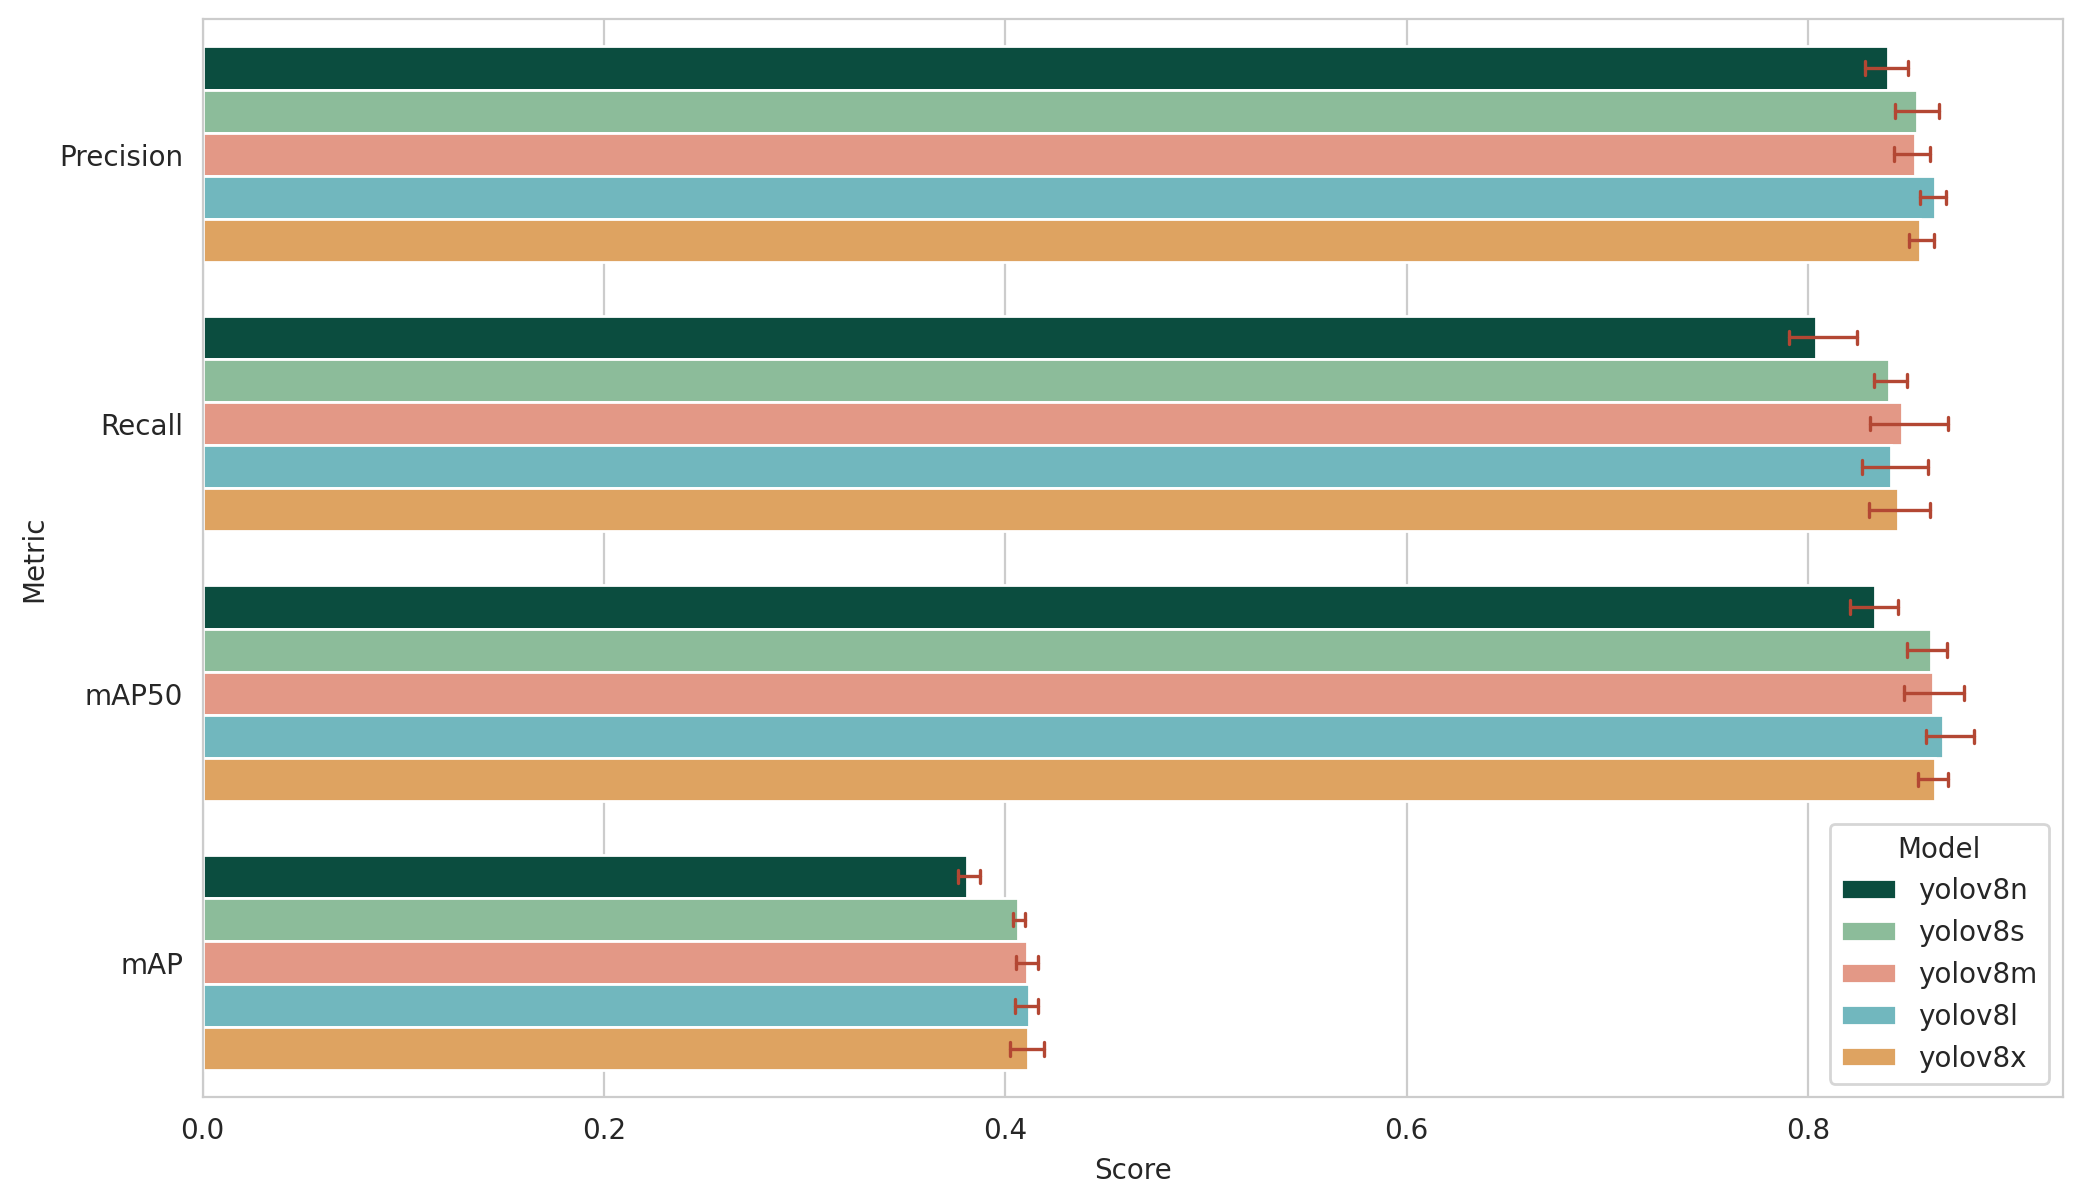

In [8]:
#| echo: False
#| label: fig-cvres
#| fig-cap: 5-fold crossvalidation results for different model architectures.

custom_lines = [Line2D([0], [0], color=syke5(0.0), lw=4),
                Line2D([0], [0], color=syke5(.25), lw=4),
                Line2D([0], [0], color=syke5(.50), lw=4),
                Line2D([0], [0], color=syke5(.75), lw=4),
                Line2D([0], [0], color=syke5(1.0), lw=4),]

pres = []
recs = []
mAP50s = []
mAPs = []

models = ['yolov8n_Adam', 'yolov8s_Adam', 'yolov8m_Adam',
          'yolov8l_Adam', 'yolov8x_Adam']
folds = os.listdir(model_path/models[1])

results = []
for m in models:
    for f in folds:
        res = pd.read_csv(model_path/m/f/'results.csv')
        res.rename(columns=lambda x: x.strip(), inplace=True)
        pre = np.array(res['metrics/precision(B)']).max()
        rec = np.array(res['metrics/recall(B)']).max()
        mAP50 = np.array(res['metrics/mAP50(B)']).max()
        mAP = np.array(res['metrics/mAP50-95(B)']).max()
        
        results.append([m.split('_')[0],f,pre, rec, mAP50, mAP])
resdf = pd.DataFrame(columns=['Model', 'fold', 'Precision', 'Recall', 'mAP50', 'mAP'], data=results)
sns.set_style('whitegrid')
fig, ax = plt.subplots(1,1, figsize=(12,7), dpi=200)
ax.set_ylim([0,1])
sns.barplot(y='variable', x='value', hue='Model', data=pd.melt(resdf, id_vars=['Model', 'fold']),
            palette=colors, errorbar=('ci', 100), capsize=.05, errcolor='#b34733', errwidth=1.2)
sns.move_legend(ax, 'lower right')
plt.ylabel('Metric')
plt.xlabel('Score')

plt.show()

# Test set results

Example results are acquired with the `yolov8x` model with best validation score. The predictions are also cleaned using the following steps:

1. All prediction whose centroid points are not located on water are discarded. The water mask used contains layers `jarvi` (Lakes), `meri` (Sea) and `virtavesialue` (Rivers as polygon geometry) from the Topographical database by the National Land Survey of Finland. Unfortunately this also discards all points not within the Finnish borders.
2. All predictions whose centroid points are located on water rock areas are discarded. The mask is the layer `vesikivikko` (Water rock areas) from the Topographical database.
3. All predictions that contain an above water rock within the bounding box are discarded. The mask contains classes `38511`, `38512`, `38513` from the layer `vesikivi` in the Topographical database.
4. All predictions that contain a lighthouse or a sector light within the bounding box are discarded. Lighthouses and sector lights come from Väylävirasto data, `ty_njr` class ids are 1, 2, 3, 4, 5, 8
5. All predictions that are wind turbines, found in Topographical database layer `tuulivoimalat`
6. TODO Filter aquaculture and net pens as soon as suitable layer for them is found
7. All predictions that are obviously too large are discarded. The prediction is defined to be "too large" if either of its edges is longer than 750 meters.

Evaluate the results with COCO metrics.

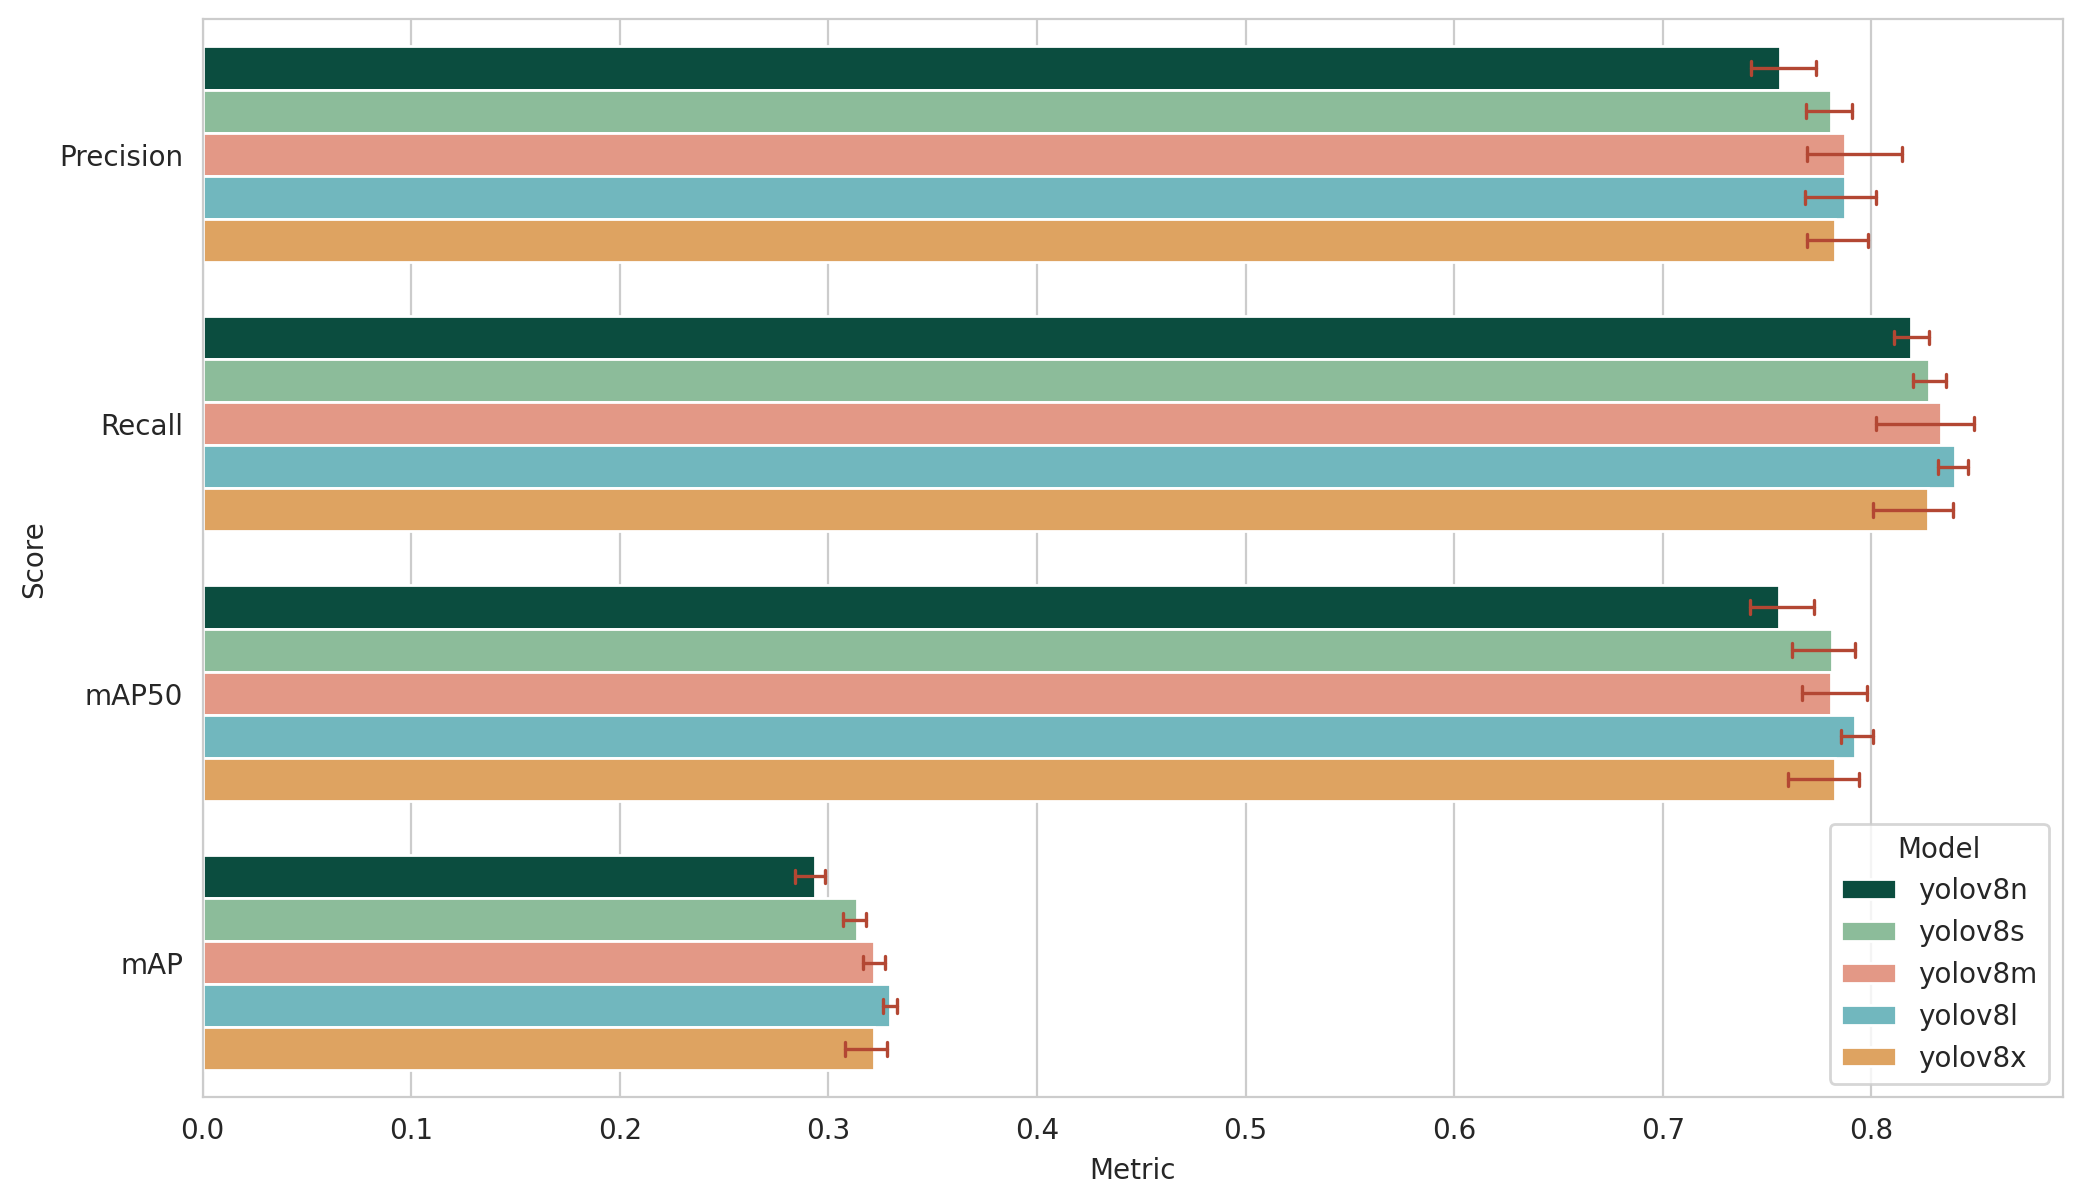

In [7]:
#| echo: False
#| label: fig-testres
#| fig-cap: Test set results by model architecture.

def compute_precision_recall(pred_gdf: gpd.GeoDataFrame, gt_gdf: gpd.GeoDataFrame, iou_threshold: float) -> tuple[float, float]:
    """
    Compute precision and recall for polygon predictions and ground truth dataframes.

    Args:
        pred_gdf (geopandas.GeoDataFrame): Dataframe containing polygon predictions
        gt_gdf (geopandas.GeoDataFrame): Dataframe containing ground truth polygons
        iou_threshold (float): The intersection-over-union threshold to use for matching polygons.

    Returns:
        tuple: (precision, recall) as floats.
    """

    # Copy the dataframes to avoid modifying the originals
    pred_gdf_copy = pred_gdf.copy()
    gt_gdf_copy = gt_gdf.copy()

    # Count the number of true positives, false positives, and false negatives
    true_positives = 0
    false_positives = 0
    false_negatives = 0

    for index, pred_row in pred_gdf_copy.iterrows():
        # Find the ground truth polygons that overlap with the prediction
        overlapping_gts = gt_gdf_copy[gt_gdf_copy.geometry.intersects(pred_row.geometry)]
        if overlapping_gts.empty:
            false_positives += 1
        else:
            # Compute IoU between the prediction and overlapping ground truth polygons
            ious = overlapping_gts.geometry.intersection(pred_row.geometry).area / overlapping_gts.geometry.union(pred_row.geometry).area

            # Find the maximum IoU and corresponding index
            max_iou = np.max(ious.values)
            max_iou_index = np.argmax(ious.values)
            # If the maximum IoU is greater than the threshold, it's a true positive
            if max_iou >= iou_threshold:
                true_positives += 1

                # Remove the matched ground truth polygon to avoid double counting
                gt_gdf_copy.drop(overlapping_gts.index[max_iou_index], inplace=True)
            else:
                false_positives += 1

    # Any remaining ground truth polygons are false negatives
    false_negatives = len(gt_gdf_copy)
    # Compute precision and recall
    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)

    return precision, recall

precs = []
recs = []
results = []
for m in models:
    mpre = []
    mrec = []
    for f in folds:
        fpre = []
        frec = []
        fap50 = []
        fmap = []
        tiles = os.listdir(f'../results/{m}/{f}')
        # Evaluate precision and recall
        for t in tiles:
            tsteps = [f for f in os.listdir(f'../data/annotated_ships/{t}') if f.endswith('shp')]
            for tstep in tsteps:
                targs = gpd.read_file(f'../data/annotated_ships/{t}/{tstep}')
                preds = gpd.read_file(f"../results/{m}/{f}/{t}/{tstep.replace('shp', 'geojson')}")
                pre, rec = compute_precision_recall(preds, targs, 0.5)
                fpre.append(pre)
                frec.append(rec)
                
        # Get mAP50 and mAP
        with open(f'../runs/{m}/{f}/eval.txt') as r:
            lines = [l.strip() for l in r.readlines()]
        lines = [l for l in lines if 'Average' in l][10:]
        mAP50 = float(lines[1].split('=')[-1].strip())
        mAP = float(lines[0].split('=')[-1].strip())
        results.append([m.split('_')[0],f,np.mean(fpre),np.mean(frec), mAP50, mAP])
        mpre.append(np.mean(fpre))
        mrec.append(np.mean(frec))
    precs.append(mpre)
    recs.append(mrec)
resdf = pd.DataFrame(columns=['Model', 'fold', 'Precision', 'Recall', 'mAP50', 'mAP'], data=results)
sns.set_style('whitegrid')
fig, ax = plt.subplots(1,1, figsize=(12,7), dpi=200)
ax.set_ylim([0,1])
sns.barplot(y='variable', x='value', hue='Model', data=pd.melt(resdf, id_vars=['Model', 'fold']),
            palette=colors, errorbar=('ci', 100), capsize=.05, errcolor='#b34733', errwidth=1.2)
sns.move_legend(ax, 'lower right')
plt.xlabel('Metric')
plt.ylabel('Score')

plt.show()